In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install albumentations --upgrade
!pip3 install fingerprint_enhancer

     |████████████████████████████████| 81kB 4.6MB/s 
     |████████████████████████████████| 952kB 9.3MB/s 
     |████████████████████████████████| 38.2MB 87kB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 14.6MB 112kB/s 
  Created wheel for fingerprint-enhancer: filename=fingerprint_enhancer-0.0.11-cp37-none-any.whl size=8045 sha256=bec723b5bf0d581ae375532e6d3e2e3f6d7f06a03431ed72ee1a180c5e45e50a
  Stored in directory: /root/.cache/pip/wheels/88/45/5c/3d34ba8efab7e215b7e8cb712752e2aa24ef12cb7e75fc6d22
Successfully built fingerprint-enhancer
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.19.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.

## Saving Pre-Processing Images (Augmentation)

In [ ]:
import cv2
from PIL import Image, ImageOps, ImageEnhance
import numpy as np
import os
import random
from skimage import util, filters, morphology
from os.path import basename, join
import numpy as np

# global variables
EXPAND_WIDTH = 220
EXPAND_HEIGHT = 220

CropWidth = 220
CropHeight = 220
ExpWidth = 220
ExpHeight = 220

# get fingerprint region for crop
def get_fp_region(image, crop_width=220, crop_height=220):
    CropWidth = crop_width
    CropHeight = crop_height
    ExpWidth = EXPAND_WIDTH
    ExpHeight = EXPAND_HEIGHT

    #otsu thresholding
    thresh = filters.threshold_otsu(image)

    #morphological closing
    picBW = image > thresh
    bw = morphology.closing(image > thresh, morphology.square(3))

    cleared = bw.copy()

    img_width = image.shape[1]
    img_height = image.shape[0]

    crop_l = img_width
    crop_r = 0
    crop_t = img_height
    crop_b = 0
    for i in range(img_height):
        for j in range(img_width):
            if cleared[i, j] == False:
                if (crop_l > j):
                    crop_l = j
                if (crop_r < j):
                    crop_r = j
                if (crop_t > i):
                    crop_t = i
                if (crop_b < i):
                    crop_b = i

    if ((crop_r - crop_l) < CropWidth):
        diff = CropWidth - (crop_r - crop_l)
        if (crop_r + crop_l > CropWidth): # right
            if (img_width - crop_r > diff / 2):
                crop_r += diff / 2
                crop_l -= diff / 2
            else:
                crop_r = img_width - 1
                crop_l = crop_r - (CropWidth + 2)
        else: # left
            if (crop_l > diff / 2):
                crop_l -= diff / 2
                crop_r += diff / 2
            else:
                crop_l = 1
                crop_r = crop_l + (CropWidth + 2)
    if ((crop_b - crop_t) < CropHeight):
        diff = CropHeight - (crop_b - crop_t)
        if (crop_b + crop_t > CropHeight): # bottom
            if (img_height - crop_b > diff / 2):
                crop_b += diff / 2
                crop_t -= diff / 2
            else:
                crop_b = img_height - 1
                crop_t = crop_b - (CropHeight + 2)
        else: # top
            if (crop_t > diff / 2):
                crop_t -= diff / 2
                crop_b += diff / 2
            else:
                crop_t = 1
                crop_b = crop_t + (CropHeight + 2)

    # expand region for rotation
    crop_l = (crop_r + crop_l - CropWidth) / 2
    crop_r = crop_l + CropWidth
    crop_t = (crop_t + crop_b - CropHeight) / 2
    crop_b = crop_t + CropHeight
    crop_l = (int)(crop_l - ((ExpWidth - CropWidth) / 2))
    crop_r = (int)(crop_r + ((ExpWidth - CropWidth) / 2))
    crop_t = (int)(crop_t - ((ExpHeight - CropHeight) / 2))
    crop_b = (int)(crop_b + ((ExpHeight - CropHeight) / 2))

    # check expanded region
    diff = 0
    if (crop_l < 0):
        diff = 0 - crop_l
        crop_l = crop_l + diff
        crop_r = crop_r + diff
    if (crop_r >= img_width):
        diff = crop_r - (img_width - 1)
        crop_l = crop_l - diff
        crop_r = crop_r - diff

    diff = 0
    if (crop_t < 0):
        diff = 0 - crop_t
        crop_t = crop_t + diff
        crop_b = crop_b + diff
    if (crop_b >= img_height):
        diff = crop_b - (img_height - 1)
        crop_t = crop_t - diff
        crop_b = crop_b - diff

    return (crop_l, crop_t, crop_r, crop_b)

def cropToRegionInterest(image_arr):
    (crop_l, crop_t, crop_r, crop_b) = get_fp_region(image_arr)

    # crop for process image
    crop_x = (ExpWidth - CropWidth) / 2
    crop_y = (ExpHeight - CropHeight) / 2
    img = Image.fromarray(image_arr, 'L')
    img = img.crop([crop_l, crop_t, crop_r, crop_b])

    # single crop - save
    img_c = img.crop([crop_x, crop_y, crop_x + CropWidth, crop_y + CropHeight])
    return np.array(img_c)

## Importing libraries

In [ ]:
from glob import glob
from os.path import join, basename
from sklearn.model_selection import train_test_split
import numpy as np
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import cv2

## Reading & Splitting dataset

In [ ]:
contact_data_path = '/content/drive/MyDrive/#Fingerprint DeepLearning/otsu_dataset'
img_data = np.array(glob(join(contact_data_path, '*.jpg')))
label_data = np.array([int(basename(img).split('_')[0]) for img in img_data])

print(len(img_data))
print(len(label_data))

21840
21840


In [ ]:
img_train_val, img_test, label_train_val, label_test = train_test_split(img_data, label_data, test_size = 0.15)
img_train, img_val, label_train, label_val = train_test_split(img_train_val, label_train_val, test_size = 0.15)

print("Train: ", img_train.shape, label_train.shape)
print("Val: ", img_val.shape, label_val.shape)
print("Test: ", img_test.shape, label_test.shape)

Train:  (15779,) (15779,)
Val:  (2785,) (2785,)
Test:  (3276,) (3276,)


In [ ]:
#making to_categorical
class_count = max(list(set(label_data)))
def make_to_categorical(labels):
  return np.array([to_categorical(label-1, num_classes=class_count) for label in labels], dtype=np.int)

label_train = make_to_categorical(label_train)
label_val = make_to_categorical(label_val)
label_test = make_to_categorical(label_test)

print("Train: ", img_train.shape, label_train.shape)
print("Val: ", img_val.shape, label_val.shape)
print("Test: ", img_test.shape, label_test.shape)

Train:  (15779,) (15779, 336)
Val:  (2785,) (2785, 336)
Test:  (3276,) (3276, 336)


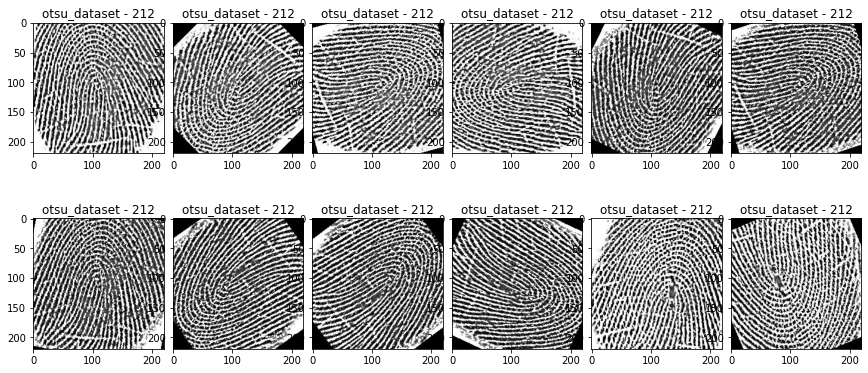

In [ ]:
#display a person
person_id = 212
custom_data = [img for img in img_data if int(basename(img).split('_')[0]) == person_id]

fig, axs = plt.subplots(2,6, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(12):
    img = cv2.imread(custom_data[i])
    axs[i].imshow(img, cmap='gray')
    
    title = str(custom_data[i]).split('/')[-2] + " - " + basename(custom_data[i]).split('_')[0]
    axs[i].set_title(title)

## Load from npy data

In [ ]:
npy_path = '/content/drive/MyDrive/#Fingerprint DeepLearning/Cross_Fingerprint_Images_Database/contact2_npy_data'

In [ ]:
np.save(join(npy_path, 'img_train.npy'), img_train)
np.save(join(npy_path, 'img_val.npy'), img_val)
np.save(join(npy_path, 'img_test.npy'), img_test)
np.save(join(npy_path, 'cat_label_train.npy'), label_train)
np.save(join(npy_path, 'cat_label_val.npy'), label_val)
np.save(join(npy_path, 'cat_label_test.npy'), label_test)

In [ ]:
# img_train = np.load(join(npy_path, 'img_train.npy'))
# img_val = np.load(join(npy_path, 'img_val.npy'))
# img_test = np.load(join(npy_path, 'img_test.npy'))
# label_train = np.load(join(cat_npy_path, 'label_train.npy'))
# label_val = np.load(join(cat_npy_path, 'label_val.npy'))
# label_test = np.load(join(cat_npy_path, 'label_test.npy'))

In [ ]:
print("Train: ", img_train.shape, label_train.shape)
print("Val: ", img_val.shape, label_val.shape)
print("Test: ", img_test.shape, label_test.shape)

Train:  (15532,) (15532, 336)
Val:  (2742,) (2742, 336)
Test:  (3230,) (3230, 336)
Real:  (336,) (336,)


## Creating Model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random

import os
import datetime

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU: ", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.4.1
Eager mode:  True
GPU:  available


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, MaxPooling2D, Activation
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
image_dim = (220,220,1) # black and white images
n_classes = max(list(set(label_data)))

model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=image_dim, kernel_size=(11,11), strides=(4,4), padding="valid"))
model.add(Activation("relu"))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid"))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding="valid"))
model.add(Activation("relu"))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid"))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="valid"))
model.add(Activation("relu"))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="valid"))
model.add(Activation("relu"))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="valid"))
model.add(Activation("relu"))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid"))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(4096))
model.add(Activation("relu"))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 2nd Fully Connected Layer
model.add(Dense(4096))
model.add(Activation("relu"))
# Add Dropout
model.add(Dropout(0.4))

# 3rd Fully Connected Layer
model.add(Dense(1000))
model.add(Activation("relu"))
# Add Dropout
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(n_classes))
model.add(Activation("softmax"))
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics="accuracy")
model.summary()

# compile
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 53, 53, 96)        11712     
_________________________________________________________________
activation (Activation)      (None, 53, 53, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       2973952   
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 384)         8

In [ ]:
import cv2
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue, RandomCrop,
    RandomBrightness, RandomContrast, RandomGamma,Normalize,CenterCrop, 
    ToFloat, ShiftScaleRotate, ToGray, RandomBrightnessContrast,RandomScale
)

AUGMENTATIONS_TRAIN = Compose([
    CenterCrop (220, 220, always_apply=True, p=1.0),
    ShiftScaleRotate(rotate_limit=(-20,20), scale_limit=0.15,
        interpolation=0, border_mode=0, value=(255, 255, 255), mask_value=None, p=0.7), 
])

AUGMENTATIONS_TEST = Compose([
    CenterCrop (220, 220, always_apply=True, p=1.0),
])

In [ ]:
# data generator definition
class DataGenerator(keras.utils.Sequence):
    def __init__(self, img_data, label_data, augmentations, batch_size = 32, shuffle = True):
        'Initialization'
        self.img_data = img_data
        self.label_data = label_data
        self.batch_size = batch_size
        self.augment_type = augmentations
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.img_data) / self.batch_size) * 2)

    def __getitem__(self, index):
        'Generate one batch of data'
        real_idx = index
        index = int(np.floor(index / 2))
        img_batch = self.img_data[index * self.batch_size : (index + 1) * self.batch_size]
        label_batch = self.label_data[index * self.batch_size : (index + 1) * self.batch_size]

        before_augment_imgs = np.array([self.read_img_as_array(dcm_path) for dcm_path in img_batch]).astype(np.uint8)

        batch_x = np.array([(self.augment_type(image = img)['image']*255).astype(np.uint8) for img in before_augment_imgs], dtype=np.uint8)
        batch_y = label_batch.astype(np.int)

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle == True:
            self.img_data, self.label_data = shuffle(self.img_data, self.label_data)

    @staticmethod
    def read_img_as_array(img_path):
        image_array = cv2.imread(img_path, 0)
        # image_array = ~enhance_Fingerprint(image_array)
        image = np.expand_dims(image_array, -1).astype(np.float64)
        image *= 255.0/image.max()
        return image.astype(np.uint8)

In [ ]:
train_gen = DataGenerator(img_train, label_train, augmentations=AUGMENTATIONS_TRAIN, shuffle = True )
val_gen = DataGenerator(img_val, label_val, augmentations=AUGMENTATIONS_TEST, shuffle = True)
test_gen = DataGenerator(img_test, label_test, augmentations=AUGMENTATIONS_TEST, shuffle = False)

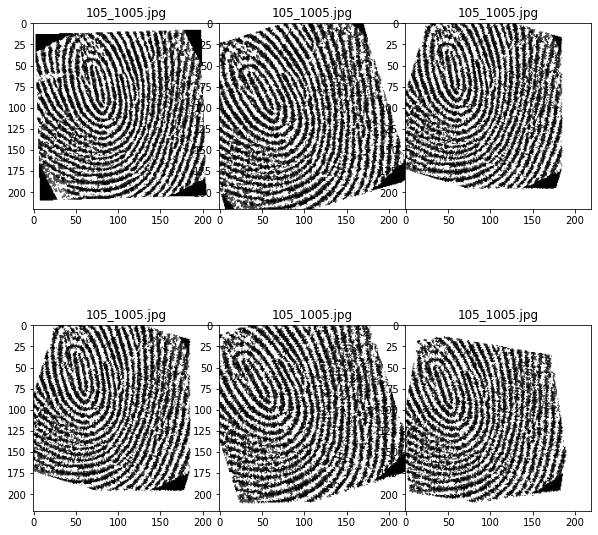

In [ ]:
from os.path import basename 

pos = 0
img = test_gen.read_img_as_array(train_gen.img_data[pos]).squeeze()
fig, axs = plt.subplots(2,3, figsize=(10,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .25, wspace=.001)
axs = axs.ravel()

for i in range(6):
    img = AUGMENTATIONS_TRAIN(image = img)['image']
    axs[i].imshow(img, cmap='gray')
    title = basename(train_gen.img_data[pos])
    axs[i].set_title(title)

## Compile & Run Model


In [ ]:
# configure checkpoint data
checkpoint_path = 'dataset_kong/model/checkpoint/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, save_weights_only = True, verbose = 1)

# prepare tensorboard
if os.name == 'nt':
    tfb_log_dir = 'dataset_kong\\logs\\train\\' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
else:
    tfb_log_dir = 'dataset_kong/logs/train/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = tfb_log_dir, histogram_freq = 1)

In [ ]:
# prepare model
# if (os.path.exists(checkpoint_path + '.index')):
#     print('continue training')
#     model.load_weights(checkpoint_path)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor="val_loss", mode="min", patience=6) 

# training model - first loop - 34 + second loop - 36
history = model.fit(train_gen, epochs = 40, validation_data = val_gen, callbacks = [cp_callback, tensorboard_callback, ])

Epoch 1/40
986/986 [==============================] - 5594s 6s/step - loss: 5.8563 - accuracy: 0.0047 - val_loss: 5.5692 - val_accuracy: 0.0079

Epoch 00001: saving model to dataset_kong/model/checkpoint/cp.ckpt
Epoch 2/40
986/986 [==============================] - 121s 123ms/step - loss: 5.5027 - accuracy: 0.0115 - val_loss: 5.2443 - val_accuracy: 0.0119

Epoch 00002: saving model to dataset_kong/model/checkpoint/cp.ckpt
Epoch 3/40
986/986 [==============================] - 120s 122ms/step - loss: 5.1983 - accuracy: 0.0187 - val_loss: 4.8702 - val_accuracy: 0.0327

Epoch 00003: saving model to dataset_kong/model/checkpoint/cp.ckpt
Epoch 4/40
986/986 [==============================] - 119s 121ms/step - loss: 4.8783 - accuracy: 0.0326 - val_loss: 4.6540 - val_accuracy: 0.0503

Epoch 00004: saving model to dataset_kong/model/checkpoint/cp.ckpt
Epoch 5/40
986/986 [==============================] - 120s 122ms/step - loss: 4.6173 - accuracy: 0.0474 - val_loss: 4.2993 - val_accuracy: 0.0729


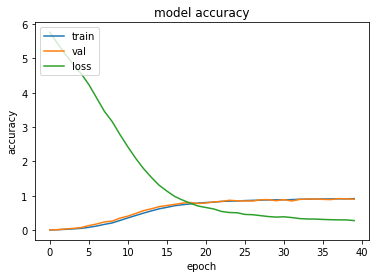

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'loss'], loc='upper left')
plt.show()

In [ ]:
print("Train: ", model.evaluate(train_gen))
print("Validation: ", model.evaluate(val_gen))
print("Test: ", model.evaluate(test_gen))

986/986 [==============================] - 102s 103ms/step - loss: 0.1282 - accuracy: 0.9599
Train:  [0.12824831902980804, 0.9599074721336365]
174/174 [==============================] - 17s 100ms/step - loss: 0.3400 - accuracy: 0.8976
Validation:  [0.3399799168109894, 0.8976293206214905]
204/204 [==============================] - 1062s 5s/step - loss: 0.3361 - accuracy: 0.9050
Test:  [0.33605119585990906, 0.905024528503418]


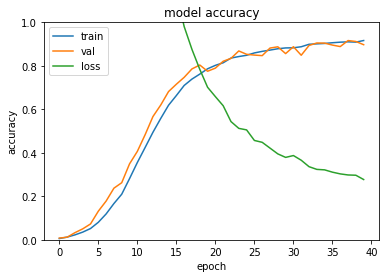

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'loss'], loc='upper left')
x1,x2,y1,y2 = plt.axis()  
plt.axis((x1,x2,0,1))
plt.show()

##Save & Load Model

In [ ]:
# save model
model_path = '/content/dataset_kong/categorical_done_nooptim.h5'
model.save(model_path, include_optimizer=False)

In [ ]:

# load model
model_path = '/content/drive/MyDrive/checkpoint/kong_p6_categorical.h5'
model = tf.keras.models.load_model(model_path)
# model.summary()

## Testing

In [ ]:
img_custom = img_test[:32]
label_custom = label_test[:32]

In [ ]:
custom_gen = DataGenerator(img_custom, label_custom, augmentations=AUGMENTATIONS_TEST, shuffle = False)

print(np.argmax(model.predict(custom_gen), axis=1))
print(np.argmax(label_custom, axis=1))

[168 202  48 264   9 238   6  81 265 151  10  22   8 222 195 221 120 294
 198  84 198 196 221 211 125 120  28  50 215 206 161 119 168 202  48 264
   9 238   6  81 265 151  10  22   8 222 195 221 120 294 198  84 198 196
 221 211 125 120  28  50 215 206 161 119]
[168 202  48 264   9 238   6  96 265 151  10  22   8 222 195 221 120 294
 198  84 198 196 221 211 125 120  28 176 215 206 161 119]


In [ ]:
# check test images accuracy (without threshold - best chosen)
from os.path import basename

total = 0
error = 0
for i in range(len(img_test)):
  input1_img = test_gen.read_img_as_array(img_test[i])
  input1_img = (AUGMENTATIONS_TEST(image = input1_img)['image']*255).astype(np.uint8)
  input1_img = input1_img.reshape((1, 220, 220, 1)).astype(np.float32) #already normalized
  pred = model.predict(input1_img)[0]

  # index = np.argmax(pred)
  # print(np.argmax(pred), '-->', np.argmax(label_test[i]))

  if np.argmax(pred) != np.argmax(label_test[i]):
    error += 1
  
  total += 1

print("error: ", error)
print("total: ", total)

error:  311
total:  3276


In [ ]:
# check test images accuracy (with 0.5 prediction threshold)
from os.path import basename
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

y_pred = []
y_true = []

total = 0
error = 0
for i in range(len(img_test)):
  input1_img = test_gen.read_img_as_array(img_test[i])
  input1_img = (AUGMENTATIONS_TEST(image = input1_img)['image']*255).astype(np.uint8)
  input1_img = input1_img.reshape((1, 220, 220, 1)).astype(np.float32) #already normalized
  pred = model.predict(input1_img)[0] > 0.5

  y_pred.append(np.argmax(pred))
  y_true.append(np.argmax(label_test[i]))

  # index = np.argmax(pred)
  # print(np.argmax(pred), '-->', np.argmax(label_test[i]))

  if np.argmax(pred) != np.argmax(label_test[i]):
    error += 1
  
  total += 1

print("error: ", error)
print("total: ", total)

error:  366
total:  3276


In [ ]:
from sklearn.metrics import classification_report

mat = confusion_matrix(y_true, y_pred)
names = [f"Person #{i+1}" for i in range(336)]
print(classification_report(y_true, y_pred, target_names=names))

              precision    recall  f1-score   support

   Person #1       0.08      0.92      0.15        13
   Person #2       1.00      0.90      0.95        10
   Person #3       1.00      0.82      0.90        11
   Person #4       1.00      0.93      0.96        14
   Person #5       1.00      0.90      0.95        10
   Person #6       0.77      0.77      0.77        13
   Person #7       0.93      0.87      0.90        15
   Person #8       1.00      0.90      0.95        10
   Person #9       1.00      1.00      1.00         7
  Person #10       0.89      1.00      0.94        16
  Person #11       0.87      0.93      0.90        14
  Person #12       0.87      1.00      0.93        13
  Person #13       0.83      1.00      0.91        15
  Person #14       1.00      1.00      1.00        10
  Person #15       0.93      1.00      0.96        13
  Person #16       1.00      0.86      0.92        14
  Person #17       1.00      0.79      0.88        14
  Person #18       1.00    

## K-Fold Cross Validation  

In [ ]:
def build_model():
    image_dim = (220,220,1) # black and white images
    n_classes = max(list(set(label_data)))

    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=image_dim, kernel_size=(11,11), strides=(4,4), padding="valid"))
    model.add(Activation("relu"))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid"))

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding="valid"))
    model.add(Activation("relu"))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid"))

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="valid"))
    model.add(Activation("relu"))

    # 4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="valid"))
    model.add(Activation("relu"))

    # 5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="valid"))
    model.add(Activation("relu"))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid"))

    # Passing it to a Fully Connected layer
    model.add(Flatten())
    # 1st Fully Connected Layer
    model.add(Dense(4096))
    model.add(Activation("relu"))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.4))

    # 2nd Fully Connected Layer
    model.add(Dense(4096))
    model.add(Activation("relu"))
    # Add Dropout
    model.add(Dropout(0.4))

    # 3rd Fully Connected Layer
    model.add(Dense(1000))
    model.add(Activation("relu"))
    # Add Dropout
    model.add(Dropout(0.4))

    # Output Layer
    model.add(Dense(n_classes))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics="accuracy")
    # model.summary()
    return model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np

# Merge inputs and targets
inputs = np.concatenate((img_train, img_val, img_test), axis=0)
targets = np.concatenate((label_train, label_val, label_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=4, shuffle=False)

In [ ]:
# Save NPY
ff_no = 1
unicorn_save_path = "/content/drive/MyDrive/unicornalex_npy"

for train, test in kfold.split(inputs, targets):
  img_custom_train = list(map(lambda x: inputs[x], train))
  img_custom_train_label = list(map(lambda x: targets[x], train))

  img_custom_test = list(map(lambda x: inputs[x], test))
  img_custom_test_label = list(map(lambda x: targets[x], test))

  np.save(f"{unicorn_save_path}/unicorn_fold_{ff_no}_TRAIN_IMGS.npy", train)
  np.save(f"{unicorn_save_path}/unicorn_fold_{ff_no}_TRAIN_LABEL.npy", train)
  np.save(f"{unicorn_save_path}/unicorn_fold_{ff_no}_TEST_IMGS.npy", test)
  np.save(f"{unicorn_save_path}/unicorn_fold_{ff_no}_TEST_LABEL.npy", test)

  print(f"[{ff_no}] => Saved")
  ff_no += 1
  

[1] => Saved
[2] => Saved
[3] => Saved
[4] => Saved


In [ ]:
# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold = []
loss_per_fold = []
model_history = []

model = build_model()

img_custom_train = np.load(f"{unicorn_save_path}/unicorn_fold_{fold_no}_TRAIN_IMGS.npy")
img_custom_train_label = np.load(f"{unicorn_save_path}/unicorn_fold_{fold_no}_TRAIN_LABEL.npy")
img_custom_test = np.load(f"{unicorn_save_path}/unicorn_fold_{fold_no}_TEST_IMGS.npy")
img_custom_test_label = np.load(f"{unicorn_save_path}/unicorn_fold_{fold_no}_TEST_LABEL.npy")

train_gen = DataGenerator(img_custom_train, img_custom_train_label, augmentations=AUGMENTATIONS_TRAIN, shuffle = True )
test_gen = DataGenerator(img_custom_test, img_custom_test_label, augmentations=AUGMENTATIONS_TEST, shuffle = False)

img_custom_train = np.array(list(map(lambda x: inputs[x], train)))
img_custom_train_label = np.array(list(map(lambda x: targets[x], train)))

img_custom_test = np.array(list(map(lambda x: inputs[x], test)))
img_custom_test_label = np.array(list(map(lambda x: targets[x], test)))

train_gen = DataGenerator(img_custom_train, img_custom_train_label, augmentations=AUGMENTATIONS_TRAIN, shuffle = True )
test_gen = DataGenerator(img_custom_test, img_custom_test_label, augmentations=AUGMENTATIONS_TEST, shuffle = False)

# Generate a print
print('------------------------------------------------------------------------')
print(f'Training for fold {fold_no} ...')

# Fit data to model
history = model.fit(train_gen, validation_data=test_gen, epochs=50, callbacks=[])
model.save(f'/content/drive/MyDrive/unicornalex_npy/saved_models/model_fold{fold_no}.h5')
model_history.append(history)

# Generate generalization metrics
scores = model.evaluate(test_gen)
print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
acc_per_fold.append(scores[1] * 100)
loss_per_fold.append(scores[0])

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
1022/1022 [==============================] - 6585s 6s/step - loss: 5.8617 - accuracy: 0.0038 - val_loss: 5.6107 - val_accuracy: 0.0074
Epoch 2/50
1022/1022 [==============================] - 113s 110ms/step - loss: 5.5325 - accuracy: 0.0089 - val_loss: 5.2047 - val_accuracy: 0.0158
Epoch 3/50
1022/1022 [==============================] - 105s 103ms/step - loss: 5.2110 - accuracy: 0.0180 - val_loss: 4.8015 - val_accuracy: 0.0381
Epoch 4/50
1022/1022 [==============================] - 104s 102ms/step - loss: 4.8279 - accuracy: 0.0369 - val_loss: 4.4082 - val_accuracy: 0.0660
Epoch 5/50
1022/1022 [==============================] - 104s 102ms/step - loss: 4.3664 - accuracy: 0.0678 - val_loss: 3.6325 - val_accuracy: 0.1489
Epoch 6/50
1022/1022 [==============================] - 104s 102ms/step - loss: 3.7406 - accuracy: 0.1296 - val_loss: 3.0525 - val_accuracy: 0.2404
Epoch 7/50
1022/1

In [ ]:
# K-fold Cross Validation model evaluation - 2 

# Increase fold number
fold_no = 2

model = build_model()

img_custom_train = np.load(f"{unicorn_save_path}/unicorn_fold_{fold_no}_TRAIN_IMGS.npy")
img_custom_train_label = np.load(f"{unicorn_save_path}/unicorn_fold_{fold_no}_TRAIN_LABEL.npy")
img_custom_test = np.load(f"{unicorn_save_path}/unicorn_fold_{fold_no}_TEST_IMGS.npy")
img_custom_test_label = np.load(f"{unicorn_save_path}/unicorn_fold_{fold_no}_TEST_LABEL.npy")

train_gen = DataGenerator(img_custom_train, img_custom_train_label, augmentations=AUGMENTATIONS_TRAIN, shuffle = True )
test_gen = DataGenerator(img_custom_test, img_custom_test_label, augmentations=AUGMENTATIONS_TEST, shuffle = False)

img_custom_train = np.array(list(map(lambda x: inputs[x], train)))
img_custom_train_label = np.array(list(map(lambda x: targets[x], train)))

img_custom_test = np.array(list(map(lambda x: inputs[x], test)))
img_custom_test_label = np.array(list(map(lambda x: targets[x], test)))

train_gen = DataGenerator(img_custom_train, img_custom_train_label, augmentations=AUGMENTATIONS_TRAIN, shuffle = True )
test_gen = DataGenerator(img_custom_test, img_custom_test_label, augmentations=AUGMENTATIONS_TEST, shuffle = False)

# Generate a print
print('------------------------------------------------------------------------')
print(f'Training for fold {fold_no} ...')

# Fit data to model
history = model.fit(train_gen, validation_data=test_gen, epochs=50, callbacks=[])
model.save(f'/content/drive/MyDrive/unicornalex_npy/saved_models/model_fold{fold_no}.h5')
model_history.append(history)

# Generate generalization metrics
scores = model.evaluate(test_gen)
print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
acc_per_fold.append(scores[1] * 100)
loss_per_fold.append(scores[0])

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/50
1022/1022 [==============================] - 105s 102ms/step - loss: 5.8556 - accuracy: 0.0036 - val_loss: 5.5687 - val_accuracy: 0.0061
Epoch 2/50
1022/1022 [==============================] - 104s 102ms/step - loss: 5.5413 - accuracy: 0.0095 - val_loss: 5.1648 - val_accuracy: 0.0226
Epoch 3/50
1022/1022 [==============================] - 104s 102ms/step - loss: 5.1746 - accuracy: 0.0194 - val_loss: 4.8578 - val_accuracy: 0.0331
Epoch 4/50
1022/1022 [==============================] - 104s 102ms/step - loss: 4.8622 - accuracy: 0.0341 - val_loss: 4.3244 - val_accuracy: 0.0689
Epoch 5/50
1022/1022 [==============================] - 104s 102ms/step - loss: 4.4193 - accuracy: 0.0643 - val_loss: 3.8262 - val_accuracy: 0.1197
Epoch 6/50
1022/1022 [==============================] - 104s 102ms/step - loss: 3.9234 - accuracy: 0.1067 - val_loss: 3.3209 - val_accuracy: 0.1904
Epoch 7/50
1022

In [ ]:
# K-fold Cross Validation model evaluation - 2 

# Increase fold number
fold_no = 3

model = build_model()

img_custom_train = np.load(f"{unicorn_save_path}/unicorn_fold_{fold_no}_TRAIN_IMGS.npy")
img_custom_train_label = np.load(f"{unicorn_save_path}/unicorn_fold_{fold_no}_TRAIN_LABEL.npy")
img_custom_test = np.load(f"{unicorn_save_path}/unicorn_fold_{fold_no}_TEST_IMGS.npy")
img_custom_test_label = np.load(f"{unicorn_save_path}/unicorn_fold_{fold_no}_TEST_LABEL.npy")

train_gen = DataGenerator(img_custom_train, img_custom_train_label, augmentations=AUGMENTATIONS_TRAIN, shuffle = True )
test_gen = DataGenerator(img_custom_test, img_custom_test_label, augmentations=AUGMENTATIONS_TEST, shuffle = False)

img_custom_train = np.array(list(map(lambda x: inputs[x], train)))
img_custom_train_label = np.array(list(map(lambda x: targets[x], train)))

img_custom_test = np.array(list(map(lambda x: inputs[x], test)))
img_custom_test_label = np.array(list(map(lambda x: targets[x], test)))

train_gen = DataGenerator(img_custom_train, img_custom_train_label, augmentations=AUGMENTATIONS_TRAIN, shuffle = True )
test_gen = DataGenerator(img_custom_test, img_custom_test_label, augmentations=AUGMENTATIONS_TEST, shuffle = False)

# Generate a print
print('------------------------------------------------------------------------')
print(f'Training for fold {fold_no} ...')

# Fit data to model
history = model.fit(train_gen, validation_data=test_gen, epochs=50, callbacks=[])
model.save(f'/content/drive/MyDrive/unicornalex_npy/saved_models/model_fold{fold_no}.h5')
model_history.append(history)

# Generate generalization metrics
scores = model.evaluate(test_gen)
print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
acc_per_fold.append(scores[1] * 100)
loss_per_fold.append(scores[0])

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/50
1022/1022 [==============================] - 105s 102ms/step - loss: 5.8635 - accuracy: 0.0037 - val_loss: 5.6232 - val_accuracy: 0.0051
Epoch 2/50
1022/1022 [==============================] - 105s 102ms/step - loss: 5.5832 - accuracy: 0.0089 - val_loss: 5.3189 - val_accuracy: 0.0180
Epoch 3/50
1022/1022 [==============================] - 104s 102ms/step - loss: 5.2651 - accuracy: 0.0172 - val_loss: 4.9751 - val_accuracy: 0.0301
Epoch 4/50
1022/1022 [==============================] - 105s 103ms/step - loss: 5.0152 - accuracy: 0.0270 - val_loss: 4.7530 - val_accuracy: 0.0371
Epoch 5/50
1022/1022 [==============================] - 104s 102ms/step - loss: 4.7867 - accuracy: 0.0379 - val_loss: 4.4727 - val_accuracy: 0.0616
Epoch 6/50
1022/1022 [==============================] - 104s 102ms/step - loss: 4.5591 - accuracy: 0.0553 - val_loss: 4.3244 - val_accuracy: 0.0792
Epoch 7/50
1022

In [ ]:
# K-fold Cross Validation model evaluation - 2 

# Increase fold number
fold_no = 4

model = build_model()

img_custom_train = np.load(f"{unicorn_save_path}/unicorn_fold_{fold_no}_TRAIN_IMGS.npy")
img_custom_train_label = np.load(f"{unicorn_save_path}/unicorn_fold_{fold_no}_TRAIN_LABEL.npy")
img_custom_test = np.load(f"{unicorn_save_path}/unicorn_fold_{fold_no}_TEST_IMGS.npy")
img_custom_test_label = np.load(f"{unicorn_save_path}/unicorn_fold_{fold_no}_TEST_LABEL.npy")

train_gen = DataGenerator(img_custom_train, img_custom_train_label, augmentations=AUGMENTATIONS_TRAIN, shuffle = True )
test_gen = DataGenerator(img_custom_test, img_custom_test_label, augmentations=AUGMENTATIONS_TEST, shuffle = False)

img_custom_train = np.array(list(map(lambda x: inputs[x], train)))
img_custom_train_label = np.array(list(map(lambda x: targets[x], train)))

img_custom_test = np.array(list(map(lambda x: inputs[x], test)))
img_custom_test_label = np.array(list(map(lambda x: targets[x], test)))

train_gen = DataGenerator(img_custom_train, img_custom_train_label, augmentations=AUGMENTATIONS_TRAIN, shuffle = True )
test_gen = DataGenerator(img_custom_test, img_custom_test_label, augmentations=AUGMENTATIONS_TEST, shuffle = False)

# Generate a print
print('------------------------------------------------------------------------')
print(f'Training for fold {fold_no} ...')

# Fit data to model
history = model.fit(train_gen, validation_data=test_gen, epochs=50, callbacks=[])
model.save(f'/content/drive/MyDrive/unicornalex_npy/saved_models/model_fold{fold_no}.h5')
model_history.append(history)

# Generate generalization metrics
scores = model.evaluate(test_gen)
print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
acc_per_fold.append(scores[1] * 100)
loss_per_fold.append(scores[0])

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/50
1022/1022 [==============================] - 105s 103ms/step - loss: 5.8804 - accuracy: 0.0032 - val_loss: 5.6531 - val_accuracy: 0.0070
Epoch 2/50
1022/1022 [==============================] - 105s 103ms/step - loss: 5.5455 - accuracy: 0.0085 - val_loss: 5.2770 - val_accuracy: 0.0143
Epoch 3/50
1022/1022 [==============================] - 105s 103ms/step - loss: 5.2756 - accuracy: 0.0150 - val_loss: 5.0057 - val_accuracy: 0.0213
Epoch 4/50
1022/1022 [==============================] - 105s 102ms/step - loss: 4.9636 - accuracy: 0.0290 - val_loss: 4.8153 - val_accuracy: 0.0353
Epoch 5/50
1022/1022 [==============================] - 105s 103ms/step - loss: 4.6909 - accuracy: 0.0434 - val_loss: 4.4457 - val_accuracy: 0.0619
Epoch 6/50
1022/1022 [==============================] - 105s 102ms/step - loss: 4.4058 - accuracy: 0.0658 - val_loss: 4.2144 - val_accuracy: 0.0875
Epoch 7/50
1022

In [ ]:
history_path = '/content/drive/MyDrive/unicornalex_npy/saved_history'

for i in range(4):
  np.save(f"{history_path}/model_history{i+1}.npy", np.array(model_history[i].history))

np.save(f"{history_path}/loss_per_fold.npy", np.array(loss_per_fold))
np.save(f"{history_path}/acc_per_fold.npy", np.array(acc_per_fold))

In [ ]:
acc_per_fold

[94.26470398902893, 92.35293865203857, 88.65808844566345, 92.05882549285889]

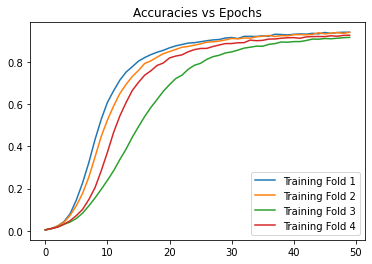

In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')
plt.plot(model_history[3].history['accuracy'], label='Training Fold 4')
plt.legend()
plt.show()

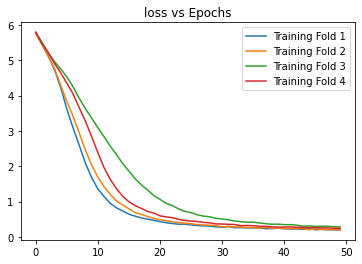

In [ ]:
plt.title('loss vs Epochs')
plt.plot(model_history[0].history['loss'], label='Training Fold 1')
plt.plot(model_history[1].history['loss'], label='Training Fold 2')
plt.plot(model_history[2].history['loss'], label='Training Fold 3')
plt.plot(model_history[3].history['loss'], label='Training Fold 4')
plt.legend()
plt.show()

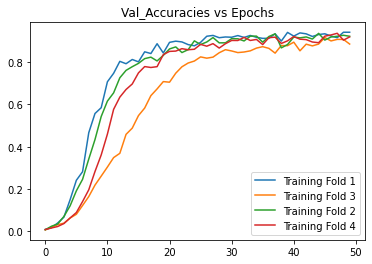

In [ ]:
plt.title('Val_Accuracies vs Epochs')
plt.plot(model_history[0].history['val_accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['val_accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['val_accuracy'], label='Training Fold 3')
plt.plot(model_history[3].history['val_accuracy'], label='Training Fold 4')
plt.legend()
plt.show()

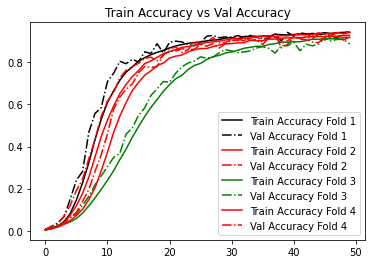

In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='red', )
plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='red', linestyle = "dashdot")
plt.legend()
plt.show()